# Text and images: Getting Started with Multimodal on Sagemaker
Information in the real world usually comes as different sensory input/output channels, like: images that can be associated with text explanations; or text that contains images to more clearly express the main idea of the article. 
*Multimodal learning* is a good model to represent the joint representations of different modalities.
In this talk  we would provide a gentle introduction to Multimodal learning and would train and deploy a multimodal predictor based on natural language text, images and tabular data using SageMaker and AutoGloun.

We will train a model that takes pet NLP descriptions, images and tabular features to predict how fast (category) they will get adopted.


## Step 1: Install libraries and prepare environment 
! Important: this workshop was tested on ml.g4dn.8xlarge, 200 GB (!!!), conda_mxnet_p37 kernel 

Because 'llvmlite' is a distutils installed project, pip is not able to remove it. 
Let's remove it manually.

In [ ]:
%%time 
!find /home/ec2-user/anaconda3 -type f -name '*llvmlite*.egg-info' -delete

Next, we'll upgrade pip amd install autogluon lib.

In [ ]:
%pip install -U pip
%pip install -U setuptools wheel
%pip install -U mxnet<2.0.0
%pip install autogluon --ignore-installed
%pip install -U sagemaker

To ensure we can run local mode, increase the conda memory to 95%.

In [4]:
!cp -f image.py /home/ec2-user/anaconda3/envs/mxnet_p37/lib/python3.7/site-packages/sagemaker/local/image.py

In [ ]:
# only run the below cells when you are using sagemaker notebook instances
!bash ./prepare-docker.sh

In [ ]:
!wget -q https://raw.githubusercontent.com/aws-samples/amazon-sagemaker-script-mode/master/local_mode_setup.sh
!/bin/bash ./local_mode_setup.sh

Restart the kernel

In [ ]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True) #automatically restarts kernel

## Step 2: Download and explore data

In [1]:
import sagemaker
import os
import subprocess
from sagemaker.mxnet import MXNet
from autogluon.core.utils.loaders import load_zip
from sagemaker.s3 import S3Uploader, s3_path_join

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/DEMO-autogluon-text-image-multimodel"
region = sagemaker_session.boto_region_name
account_id = sagemaker_session.account_id()
role = sagemaker.get_execution_role()

In [2]:
download_dir = './ag_automm_tutorial'
zip_file = 'https://automl-mm-bench.s3.amazonaws.com/petfinder_for_tutorial.zip'

In [ ]:
%%time
load_zip.unzip(zip_file, unzip_dir=download_dir)

Explore the data

In [4]:
import pandas as pd
dataset_path = download_dir + '/petfinder_for_tutorial'
train_data = pd.read_csv(f'{dataset_path}/train.csv', index_col=0)
test_data = pd.read_csv(f'{dataset_path}/test.csv', index_col=0)
label_col = 'AdoptionSpeed'

In [5]:
image_col = 'Images'
train_data[image_col] = train_data[image_col].apply(lambda ele: ele.split(';')[0]) # Use the first image for a quick tutorial
test_data[image_col] = test_data[image_col].apply(lambda ele: ele.split(';')[0])


def path_expander(path, base_folder):
    path_l = path.split(';')
    return ';'.join([os.path.abspath(os.path.join(base_folder, path)) for path in path_l])

train_data[image_col] = train_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
test_data[image_col] = test_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))

train_data[image_col].iloc[0]

'/home/ec2-user/SageMaker/sagemaker-multimodal-workshop/ag_automm_tutorial/petfinder_for_tutorial/images/7d7a39d71-1.jpg'

In [ ]:
train_data['AdoptionSpeed'].hist()

In [ ]:
train_data.hist(figsize=(20,20))

In [8]:
example_row = train_data.iloc[0]

example_row

Type                                                             2
Name                                                 Yumi Hamasaki
Age                                                              4
Breed1                                                         292
Breed2                                                         265
Gender                                                           2
Color1                                                           1
Color2                                                           5
Color3                                                           7
MaturitySize                                                     2
FurLength                                                        2
Vaccinated                                                       1
Dewormed                                                         3
Sterilized                                                       2
Health                                                        

In [9]:
example_row['Description']


"I rescued Yumi Hamasaki at a food stall far away in Kelantan. At that time i was on my way back to KL, she was suffer from stomach problem and looking very2 sick.. I send her to vet & get the treatment + vaccinated and right now she's very2 healthy.. About yumi : - love to sleep with ppl - she will keep on meowing if she's hugry - very2 active, always seeking for people to accompany her playing - well trained (poo+pee in her own potty) - easy to bathing - I only feed her with these brands : IAMS, Kittenbites, Pro-formance Reason why i need someone to adopt Yumi: I just married and need to move to a new house where no pets are allowed :( As Yumi is very2 special to me, i will only give her to ppl that i think could take care of her just like i did (especially on her foods things).."

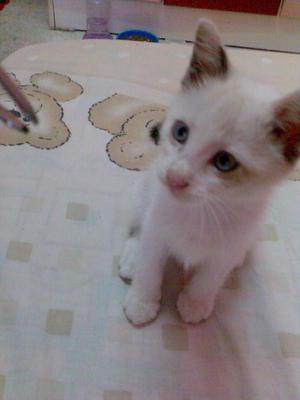

In [10]:
example_image = example_row[image_col]

from IPython.display import Image, display
pil_img = Image(filename=example_image)
display(pil_img)

Upload to s3

In [11]:
s3_data_path = s3_path_join("s3://", bucket, f"{prefix}/data")
dataset_path = download_dir + '/petfinder_for_tutorial'
print(f"Uploading data to {s3_data_path}")
data_uri = S3Uploader.upload(dataset_path, s3_data_path)

Uploading data to s3://sagemaker-eu-west-2-327838496401/sagemaker/DEMO-autogluon-text-image-multimodel/data


## Train the model

In [12]:
instance_type = "local"

try:
    if subprocess.call("nvidia-smi") == 0:
        ## Set type to GPU if one is present
        instance_type = "local_gpu"
except:
    pass

print("Instance type = " + instance_type)

Instance type = local_gpu


In [13]:
from sagemaker import image_uris

In [14]:
image_uri = image_uris.retrieve(
            "autogluon",
            region=region,
            version="0.5",
            py_version="py38",
            image_scope="training",
            instance_type="local_gpu",
        )

In [15]:
from sagemaker.estimator import Estimator

In [16]:
model_artifacts_location = f"s3://{bucket}/{prefix}/artifacts"
mnist_estimator = Estimator(
    entry_point="train.py",
    role=role,
    output_path=model_artifacts_location,
    instance_count=1,
    instance_type="local_gpu",
    image_uri=image_uri,
    volume_size=200
)

In [ ]:
mnist_estimator.fit({"training": data_uri})

Creating o9nbfh44op-algo-1-jf408 ... 
Creating o9nbfh44op-algo-1-jf408 ... done
Attaching to o9nbfh44op-algo-1-jf408
o9nbfh44op-algo-1-jf408 | 2022-09-13 14:02:56,281 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
o9nbfh44op-algo-1-jf408 | 2022-09-13 14:02:56,307 sagemaker-training-toolkit INFO     instance_groups entry not present in resource_config
o9nbfh44op-algo-1-jf408 | 2022-09-13 14:02:56,308 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1-jf408"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{}', 'SM_USER_ENTRY_POINT': 'train.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1-jf408","hosts":["algo-1-jf408"]}', 'SM_INPUT_DATA_CONFIG': '{"training":{"TrainingInputMode":"File"}}', 'SM_OUTPUT_DATA_DIR': '/opt/ml/output/data', 'SM_CHANNELS': '["training"]', 'SM_CURRENT_HOST': 'algo-1-jf408', 'SM_CURRENT_INSTANCE_TYPE': 'local', 'SM_CURRENT_INSTANCE_GROUP': 'hom

## Inference

In [26]:
inference_image_uri = image_uris.retrieve(
            "autogluon",
            region=region,
            version="0.5",
            py_version="py38",
            image_scope="inference",
            instance_type="local",
        )

In [27]:
from sagemaker.model import Model

In [39]:
trained_model_artifacts_location = mnist_estimator.model_data

In [45]:
from sagemaker import LocalSession

mm_inference_estimator = Model(
    entry_point="inference.py",
    source_dir = "code",
    role=role,
    model_data=trained_model_artifacts_location,
    image_uri=inference_image_uri,
    sagemaker_session=LocalSession()
)

In [ ]:
predictor = mm_inference_estimator.deploy(initial_instance_count=1, instance_type="local", endpoint_name="mm-ag-model", wait=True)

In [47]:
from sagemaker.predictor import Predictor
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import NumpySerializer, JSONSerializer
from sagemaker import LocalSession


#TODO: FIX REAL SERIALIZATION
predictor = Predictor(endpoint_name="mm-ag-model",
                          sagemaker_session=LocalSession(),
                          serializer=sagemaker.serializers.JSONSerializer(),
                          deserializer=sagemaker.deserializers.JSONDeserializer()
                     )

In [ ]:
#TODO: put real data
r=predictor.predict({"sdsdsd":"sdsdsdsd"})

In [ ]:
predictor.delete_endpoint()